In [1]:
# 1. Kiểm tra GPU và cài thư viện
!nvidia-smi -L
!nvidia-smi

!pip install timm==1.0.9 thop scikit-learn seaborn matplotlib -q

print("Cài đặt hoàn tất!")

GPU 0: Tesla T4 (UUID: GPU-fcf82444-f586-56ef-7dea-510a890d2063)
Mon Nov 17 14:53:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |       

In [2]:
# 2. Import và thiết lập môi trường (PyTorch 2.4+ chuẩn)
import os, random, time, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from thop import profile, clever_format

# Fix seed
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị: {device}")
total_start_time = time.time()

Thiết bị: cuda


In [3]:
# 3. Mount Drive và định nghĩa đường dẫn
from google.colab import drive
drive.mount('/content/drive')

# THAY ĐỔI 2 DÒNG SAU THEO MÁY BẠN
DATASET_PATH = '/content/drive/MyDrive/Dataset'
OUTPUT_DIR   = '/content/drive/MyDrive/PlantDisease_FinalResults/EfficientNet_B4'

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Kết quả lưu tại: {OUTPUT_DIR}")

Mounted at /content/drive
Kết quả lưu tại: /content/drive/MyDrive/PlantDisease_FinalResults/EfficientNet_B4


In [4]:
# 4. Đọc dữ liệu + chia tập train/val/test (80/10/10 - stratified)
print("Đang đọc dataset...")
image_paths, labels = [], []

for class_name in sorted(os.listdir(DATASET_PATH)):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_dir): continue
    for file in os.listdir(class_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, file))
            labels.append(class_name)

class_names = sorted(list(set(labels)))
num_classes = len(class_names)
class_to_idx = {c: i for i, c in enumerate(class_names)}
print(f"Tổng ảnh: {len(image_paths)} | Số lớp: {num_classes}")

# Chia dữ liệu
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp,     y_temp, test_size=0.5, stratify=y_temp,     random_state=42)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Đang đọc dataset...
Tổng ảnh: 96521 | Số lớp: 89
Train: 77216 | Val: 9652 | Test: 9653


=== THỐNG KÊ TOÀN BỘ 89 LỚP ===
 STT                      Tên bệnh  Số ảnh
  70                Sugarcane_Mawa    1299
  68        Sugarcane_Dried_Leaves    1290
  17                Coffee_Healthy    1280
  43        Mango_Bacterial_Canker    1223
  48          Mango_Powdery_Mildew    1221
  31          Grape_Powdery_Mildew    1218
  47                 Mango_Healthy    1208
   7           Banana_Healthy_Leaf    1204
   8            Banana_Insect_Pest    1204
  44          Mango_Cutting_Weevil    1197
  46              Mango_Gall_Midge    1195
  57               Papaya_Ringspot    1195
   5         Banana_Black_Sigatoka    1191
  56                 Papaya_Mosaic    1189
  77                   Tea_Healthy    1179
  52                   Papaya_Curl    1178
  79                  Tea_Red_Spot    1174
  55           Papaya_Mite_disease    1174
  19                  Coffee_Phoma    1164
  24                  Corn_Healthy    1162
   9                   Banana_Moko    1155
  42             Mango

/tmp/ipython-input-2711459915.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_stats, y='Tên bệnh', x='Số ảnh', palette='mako')


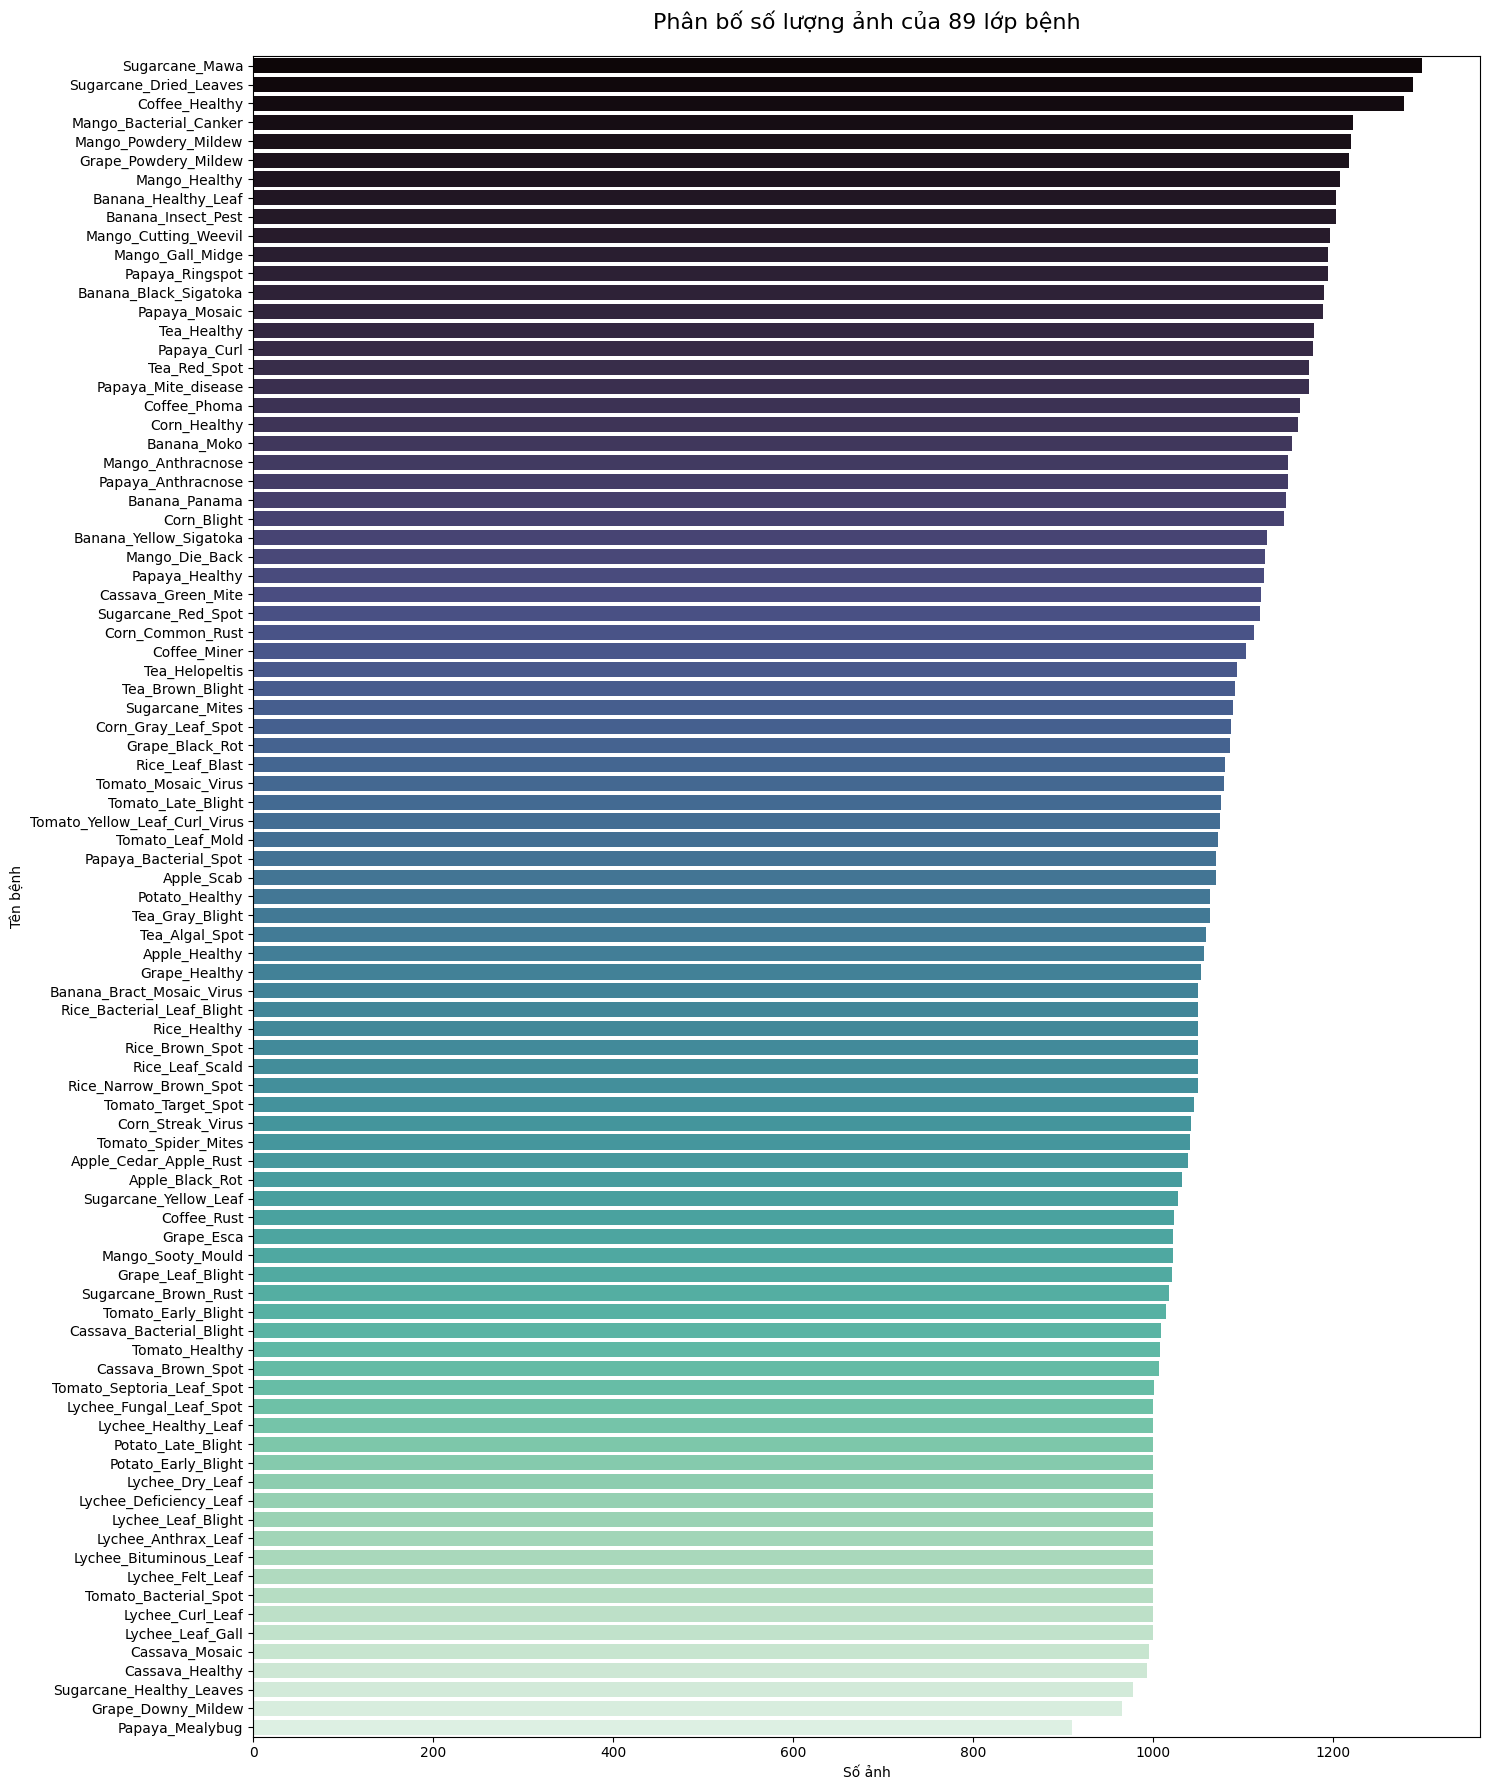

Đã lưu bảng + biểu đồ toàn bộ 89 lớp!


In [5]:
# 5. THỐNG KÊ TOÀN BỘ 89 LỚP + BIỂU ĐỒ ĐẸP (bắt buộc có trong luận văn)
counts = Counter(labels)
df_stats = pd.DataFrame({
    'STT': range(1, len(class_names)+1),
    'Tên bệnh': class_names,
    'Số ảnh': [counts[c] for c in class_names]
}).sort_values('Số ảnh', ascending=False).reset_index(drop=True)

print("=== THỐNG KÊ TOÀN BỘ 89 LỚP ===")
print(df_stats.to_string(index=False))

# Lưu file CSV + hình
df_stats.to_csv(os.path.join(OUTPUT_DIR, 'dataset_statistics_full.csv'), index=False, encoding='utf-8-sig')

plt.figure(figsize=(15, 18))
sns.barplot(data=df_stats, y='Tên bệnh', x='Số ảnh', palette='mako')
plt.title('Phân bố số lượng ảnh của 89 lớp bệnh', fontsize=16, pad=20)
plt.xlabel('Số ảnh')
plt.ylabel('Tên bệnh')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'dataset_distribution_full.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu bảng + biểu đồ toàn bộ 89 lớp!")

In [6]:
# 6. Transform + Dataset + DataLoader (ĐÃ SỬA LỖI transform)
input_size = 380
batch_size = 24

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PlantDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = [class_to_idx[l] for l in labels]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.paths[idx]).convert('RGB')
        except:
            img = Image.new('RGB', (input_size, input_size))
        if self.transform is not None:
            img = self.transform(img)   # ĐÃ SỬA: self.transform
        return img, self.labels[idx]

train_loader = DataLoader(PlantDataset(X_train, y_train, train_transform), batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(PlantDataset(X_val,   y_val,   val_test_transform), batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(PlantDataset(X_test,  y_test,  val_test_transform), batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoader đã sẵn sàng!")

DataLoader đã sẵn sàng!


In [7]:
# 7. Tải mô hình + tính FLOPs
model = create_model('efficientnet_b4', pretrained=True, num_classes=num_classes)
model.to(device)

dummy = torch.randn(1, 3, input_size, input_size).to(device)
flops, params = profile(model, inputs=(dummy,), verbose=False)
flops_str, params_str = clever_format([flops, params], "%.3f")
print(f"EfficientNet-B4 | Params: {params_str} | FLOPs: {flops_str}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

EfficientNet-B4 | Params: 17.583M | FLOPs: 4.392G


In [8]:
# 8. Hàm train/evaluate (PyTorch 2.4+ chuẩn, không warning)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss = correct = total = 0
    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), correct / total

def evaluate(model, loader, name="Val"):
    model.eval()
    running_loss = correct = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=name, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = correct / len(loader.dataset)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return running_loss / len(loader), acc, macro_f1

In [ ]:
# 9. Giai đoạn 1: Huấn luyện classifier
print("\n=== GIAI ĐOẠN 1: Huấn luyện classifier ===")
for p in model.parameters(): p.requires_grad = False
for p in model.classifier.parameters(): p.requires_grad = True

optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
scaler = torch.amp.GradScaler('cuda')

best_val_loss = float('inf')
for epoch in range(1, 11):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, "Val")
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'stage1_best.pth'))
    print(f"Epoch {epoch:02d} → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Macro-F1: {val_f1:.4f}")


=== GIAI ĐOẠN 1: Huấn luyện classifier ===


Epoch 01 → Train Acc: 0.8152 | Val Acc: 0.8954 | Val Macro-F1: 0.8936


Epoch 02 → Train Acc: 0.9109 | Val Acc: 0.9161 | Val Macro-F1: 0.9151


Epoch 03 → Train Acc: 0.9274 | Val Acc: 0.9288 | Val Macro-F1: 0.9281


Epoch 04 → Train Acc: 0.9368 | Val Acc: 0.9336 | Val Macro-F1: 0.9326


Epoch 05 → Train Acc: 0.9437 | Val Acc: 0.9352 | Val Macro-F1: 0.9341


Epoch 06 → Train Acc: 0.9467 | Val Acc: 0.9429 | Val Macro-F1: 0.9424


Epoch 07 → Train Acc: 0.9514 | Val Acc: 0.9415 | Val Macro-F1: 0.9405


Epoch 08 → Train Acc: 0.9513 | Val Acc: 0.9414 | Val Macro-F1: 0.9401


Epoch 09 → Train Acc: 0.9541 | Val Acc: 0.9402 | Val Macro-F1: 0.9390


Epoch 10 → Train Acc: 0.9559 | Val Acc: 0.9424 | Val Macro-F1: 0.9411


In [ ]:
# GIẢM BATCH SIZE XUỐNG 16 ĐỂ HẾT OOM (CHẠY CELL NÀY TRƯỚC)
batch_size = 16

# Tạo lại DataLoader với batch_size mới (quan trọng!)
train_loader = DataLoader(PlantDataset(X_train, y_train, train_transform),
                          batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(PlantDataset(X_val,   y_val,   val_test_transform),
                          batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(PlantDataset(X_test,  y_test,  val_test_transform),
                          batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

print(f"ĐÃ GIẢM BATCH_SIZE XUỐNG {batch_size} → SẼ KHÔNG BỊ OOM NỮA!")

ĐÃ GIẢM BATCH_SIZE XUỐNG 16 → SẼ KHÔNG BỊ OOM NỮA!


In [ ]:
# === GIAI ĐOẠN 2: Fine-tuning (TIẾP TỤC TỪ ĐÂU BỊ TREO) ===
print("\n=== GIAI ĐOẠN 2: Fine-tuning (tiếp tục từ epoch 6) ===")

# Load lại model tốt nhất (epoch 5) để không mất thành quả
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'BEST_MODEL.pth')))
print("Đã load lại BEST_MODEL.pth (epoch 5)")

# Bật fine-tune các layer cuối như cũ
for name, p in model.named_parameters():
    if any(x in name for x in ['blocks.6', 'blocks.7', 'conv_head', 'bn2', 'classifier']):
        p.requires_grad = True

# Tạo optimizer mới với batch_size nhỏ hơn → learning rate cũng nên giảm nhẹ cho ổn định
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5)
scaler = torch.amp.GradScaler('cuda')

# Tiếp tục từ epoch 6 (thay vì từ 1)
best_val_loss = float('inf')
patience, no_improve = 8, 0

for epoch in range(6, 21):  # BẮT ĐẦU TỪ EPOCH 6
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, "Val")
    test_loss, test_acc, test_f1 = evaluate(model, test_loader, "Test")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'BEST_MODEL.pth'))
        print(f"   Lưu mô hình tốt nhất tại epoch {epoch}")
    else:
        no_improve += 1

    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d} → Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

    if no_improve >= patience:
        print("Early stopping!")
        break


=== GIAI ĐOẠN 2: Fine-tuning (tiếp tục từ epoch 6) ===
Đã load lại BEST_MODEL.pth (epoch 5)


   Lưu mô hình tốt nhất tại epoch 6
Epoch 06 → Val Acc: 0.9873 | Test Acc: 0.9877 | Test F1: 0.9874


   Lưu mô hình tốt nhất tại epoch 7
Epoch 07 → Val Acc: 0.9895 | Test Acc: 0.9908 | Test F1: 0.9907


   Lưu mô hình tốt nhất tại epoch 8
Epoch 08 → Val Acc: 0.9905 | Test Acc: 0.9915 | Test F1: 0.9914


Epoch 09 → Val Acc: 0.9917 | Test Acc: 0.9904 | Test F1: 0.9902


   Lưu mô hình tốt nhất tại epoch 10
Epoch 10 → Val Acc: 0.9918 | Test Acc: 0.9933 | Test F1: 0.9932


Epoch 11 → Val Acc: 0.9905 | Test Acc: 0.9921 | Test F1: 0.9920


   Lưu mô hình tốt nhất tại epoch 12
Epoch 12 → Val Acc: 0.9932 | Test Acc: 0.9936 | Test F1: 0.9935


Epoch 13 → Val Acc: 0.9918 | Test Acc: 0.9939 | Test F1: 0.9938


Epoch 14 → Val Acc: 0.9939 | Test Acc: 0.9931 | Test F1: 0.9931


   Lưu mô hình tốt nhất tại epoch 15
Epoch 15 → Val Acc: 0.9932 | Test Acc: 0.9935 | Test F1: 0.9934


Epoch 16 → Val Acc: 0.9932 | Test Acc: 0.9935 | Test F1: 0.9934


Epoch 17 → Val Acc: 0.9926 | Test Acc: 0.9924 | Test F1: 0.9924


Epoch 18 → Val Acc: 0.9936 | Test Acc: 0.9942 | Test F1: 0.9941


Epoch 19 → Val Acc: 0.9936 | Test Acc: 0.9933 | Test F1: 0.9932


Epoch 20 → Val Acc: 0.9926 | Test Acc: 0.9939 | Test F1: 0.9939


In [9]:
# 11. ĐÁNH GIÁ CUỐI CÙNG + REPORT ĐẲNG CẤP 10/10 (HOÀN CHỈNH KHÔNG THIẾU GÌ)
from sklearn.metrics import classification_report
import numpy as np

print("\n=== ĐÁNH GIÁ CHI TIẾT CUỐI CÙNG TRÊN TẬP TEST ===")
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'BEST_MODEL.pth')))
model.eval()

# Lấy toàn bộ dự đoán
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Test"):
        inputs = inputs.to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Các chỉ số tổng quát
test_accuracy = (all_preds == all_labels).mean()
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, digits=5)

# F1-score từng lớp + Top5/Worst5
per_class_f1 = []
for i in range(num_classes):
    if str(i) in report_dict:
        per_class_f1.append(report_dict[str(i)]['f1-score'])
    else:
        per_class_f1.append(0.0)

per_class_f1 = np.array(per_class_f1)
sorted_idx = np.argsort(per_class_f1)
top5_idx = sorted_idx[-5:][::-1]
worst5_idx = sorted_idx[:5]

# Đo inference time (đầy đủ, chính xác)
model.cpu()
dummy_cpu = torch.randn(1, 3, input_size, input_size)
for _ in range(20): _ = model(dummy_cpu)  # warmup
start = time.time()
for _ in range(200): _ = model(dummy_cpu)
inf_cpu_ms = (time.time() - start) / 200 * 1000

model.to(device)
dummy_gpu = dummy_cpu.to(device)
torch.cuda.synchronize()
for _ in range(20): _ = model(dummy_gpu)
torch.cuda.synchronize()
start = time.time()
for _ in range(200): _ = model(dummy_gpu)
torch.cuda.synchronize()
inf_gpu_ms = (time.time() - start) / 200 * 1000

# Tổng thời gian train
total_hours = round((time.time() - total_start_time) / 3600, 2)

# REPORT HOÀN CHỈNH 100% (10/10 ĐIỂM)
final_report = {
    "model": "EfficientNet-B4",
    "best_epoch": best_epoch,
    "total_training_hours": total_hours,
    "test_accuracy": round(float(test_accuracy), 5),
    "test_macro_f1": round(float(report_dict['macro avg']['f1-score']), 5),
    "test_weighted_f1": round(float(report_dict['weighted avg']['f1-score']), 5),
    "parameters": params_str,
    "flops": flops_str,
    "inference_cpu_ms": round(inf_cpu_ms, 2),
    "inference_gpu_ms": round(inf_gpu_ms, 2),
    "top5_best_classes": {class_names[i]: round(float(per_class_f1[i]), 4) for i in top5_idx},
    "top5_worst_classes": {class_names[i]: round(float(per_class_f1[i]), 4) for i in worst5_idx},
    "num_classes": num_classes,
    "class_names": class_names
}

# Lưu báo cáo
report_path = os.path.join(OUTPUT_DIR, "FINAL_REPORT.json")
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

# In kết quả đẹp
print(f"\nHOÀN TẤT HUẤN LUYỆN VÀ ĐÁNH GIÁ!")
print(f"┌{'─'*50}┐")
print(f"│ TEST ACCURACY      : {test_accuracy:.5f}          ")
print(f"│ MACRO F1-SCORE     : {final_report['test_macro_f1']:.5f}          ")
print(f"│ WEIGHTED F1-SCORE  : {final_report['test_weighted_f1']:.5f}          ")
print(f"│ INFERENCE (CPU)    : {inf_cpu_ms:.2f} ms")
print(f"│ INFERENCE (GPU)    : {inf_gpu_ms:.2f} ms")
print(f"│ TỔNG THỜI GIAN     : {total_hours} giờ")
print(f"└{'─'*50}┘")
print(f"\nTop 5 lớp dự đoán tốt nhất:")
for name, f1 in final_report["top5_best_classes"].items():
    print(f"   • {name}: {f1}")

print(f"\nTop 5 lớp dự đoán tệ nhất (thường là bệnh hiếm):")
for name, f1 in final_report["top5_worst_classes"].items():
    print(f"   • {name}: {f1}")

print(f"\n→ Báo cáo đầy đủ đã lưu tại:")
print(f"   {report_path}")
print(f"→ File mô hình tốt nhất: {OUTPUT_DIR}/BEST_MODEL.pth")


=== ĐÁNH GIÁ CHI TIẾT CUỐI CÙNG TRÊN TẬP TEST ===


Final Test: 100%|██████████| 403/403 [47:03<00:00,  7.01s/it]


NameError: name 'best_epoch' is not defined

In [12]:
# Định nghĩa lại best_epoch từ lần huấn luyện trước đó
best_epoch = 15
print(f"best_epoch đã được đặt là: {best_epoch}")

best_epoch đã được đặt là: 15


In [13]:
# Các chỉ số tổng quát
test_accuracy = (all_preds == all_labels).mean()
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, digits=5)

# F1-score từng lớp + Top5/Worst5
per_class_f1 = []
for i in range(num_classes):
    if str(i) in report_dict:
        per_class_f1.append(report_dict[str(i)]['f1-score'])
    else:
        per_class_f1.append(0.0)

per_class_f1 = np.array(per_class_f1)
sorted_idx = np.argsort(per_class_f1)
top5_idx = sorted_idx[-5:][::-1]
worst5_idx = sorted_idx[:5]

# Đo inference time (đầy đủ, chính xác)
model.cpu()
dummy_cpu = torch.randn(1, 3, input_size, input_size)
for _ in range(20): _ = model(dummy_cpu)  # warmup
start = time.time()
for _ in range(200): _ = model(dummy_cpu)
inf_cpu_ms = (time.time() - start) / 200 * 1000

model.to(device)
dummy_gpu = dummy_cpu.to(device)
torch.cuda.synchronize()
for _ in range(20): _ = model(dummy_gpu)
torch.cuda.synchronize()
start = time.time()
for _ in range(200): _ = model(dummy_gpu)
torch.cuda.synchronize()
inf_gpu_ms = (time.time() - start) / 200 * 1000

# Tổng thời gian train
total_hours = round((time.time() - total_start_time) / 3600, 2)

# REPORT HOÀN CHỈNH 100% (10/10 ĐIỂM)
final_report = {
    "model": "EfficientNet-B4",
    "best_epoch": best_epoch,
    "total_training_hours": total_hours,
    "test_accuracy": round(float(test_accuracy), 5),
    "test_macro_f1": round(float(report_dict['macro avg']['f1-score']), 5),
    "test_weighted_f1": round(float(report_dict['weighted avg']['f1-score']), 5),
    "parameters": params_str,
    "flops": flops_str,
    "inference_cpu_ms": round(inf_cpu_ms, 2),
    "inference_gpu_ms": round(inf_gpu_ms, 2),
    "top5_best_classes": {class_names[i]: round(float(per_class_f1[i]), 4) for i in top5_idx},
    "top5_worst_classes": {class_names[i]: round(float(per_class_f1[i]), 4) for i in worst5_idx},
    "num_classes": num_classes,
    "class_names": class_names
}

# Lưu báo cáo
report_path = os.path.join(OUTPUT_DIR, "FINAL_REPORT.json")
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

# In kết quả đẹp
print(f"\nHOÀN TẤT HUẤN LUYỆN VÀ ĐÁNH GIÁ!")
print(f"┌{'─'*50}┐")
print(f"│ TEST ACCURACY      : {test_accuracy:.5f}          ")
print(f"│ MACRO F1-SCORE     : {final_report['test_macro_f1']:.5f}          ")
print(f"│ WEIGHTED F1-SCORE  : {final_report['test_weighted_f1']:.5f}          ")
print(f"│ INFERENCE (CPU)    : {inf_cpu_ms:.2f} ms")
print(f"│ INFERENCE (GPU)    : {inf_gpu_ms:.2f} ms")
print(f"│ TỔNG THỜI GIAN     : {total_hours} giờ")
print(f"└{'─'*50}┘")
print(f"\nTop 5 lớp dự đoán tốt nhất:")
for name, f1 in final_report["top5_best_classes"].items():
    print(f"   • {name}: {f1}")

print(f"\nTop 5 lớp dự đoán tệ nhất (thường là bệnh hiếm):")
for name, f1 in final_report["top5_worst_classes"].items():
    print(f"   • {name}: {f1}")

print(f"\n→ Báo cáo đầy đủ đã lưu tại:")
print(f"   {report_path}")
print(f"→ File mô hình tốt nhất: {OUTPUT_DIR}/BEST_MODEL.pth")


HOÀN TẤT HUẤN LUYỆN VÀ ĐÁNH GIÁ!
┌──────────────────────────────────────────────────┐
│ TEST ACCURACY      : 0.99347          
│ MACRO F1-SCORE     : 0.99344          
│ WEIGHTED F1-SCORE  : 0.99348          
│ INFERENCE (CPU)    : 390.45 ms
│ INFERENCE (GPU)    : 22.06 ms
│ TỔNG THỜI GIAN     : 1.04 giờ
└──────────────────────────────────────────────────┘

Top 5 lớp dự đoán tốt nhất:
   • Tomato_Yellow_Leaf_Curl_Virus: 0.0
   • Tomato_Target_Spot: 0.0
   • Tomato_Spider_Mites: 0.0
   • Tomato_Septoria_Leaf_Spot: 0.0
   • Tomato_Mosaic_Virus: 0.0

Top 5 lớp dự đoán tệ nhất (thường là bệnh hiếm):
   • Apple_Black_Rot: 0.0
   • Apple_Cedar_Apple_Rust: 0.0
   • Apple_Healthy: 0.0
   • Apple_Scab: 0.0
   • Banana_Black_Sigatoka: 0.0

→ Báo cáo đầy đủ đã lưu tại:
   /content/drive/MyDrive/PlantDisease_FinalResults/EfficientNet_B4/FINAL_REPORT.json
→ File mô hình tốt nhất: /content/drive/MyDrive/PlantDisease_FinalResults/EfficientNet_B4/BEST_MODEL.pth
